# Test case
This notebook describes a complete test, from generating images to creating a stiched image
## Generating image
Images are generated in temporary directory using `alpenglow/test/image_generator` script.

In [26]:
import alpenglow.image_generator as ig
from skimage import data
import matplotlib.pyplot as plt
import tempfile
import numpy

directory = tempfile.mkdtemp()
image = data.camera()
print(numpy.concatenate([image[0:3, 0:6],image[0:3, :511:-1]],axis=1))
print(image[0:3, :505:-1])
print([image[0:512,:].shape, image.shape])
print(uint8.max)

plt.imshow(image[0:100,:], cmap='gray')
plt.show()

files_per_strip = 2
number_of_strips = 4
overlap=0.35

nchan=2

ig.generate(image, number_of_strips, destination=directory, overlap=overlap, blur_levels=files_per_strip, margins=(0, 38, 19))

[[156 157 160 159 158 156]
 [156 157 159 158 158 156]
 [158 157 156 156 157 157]]
[[152 152 152 151 150 151]
 [152 152 152 151 150 151]
 [152 152 152 153 152 153]]
[(512, 512), (512, 512)]


NameError: name 'uint8' is not defined

In [50]:
from os import listdir
print(listdir(directory))

['00_00.tif', '00_01.tif', '02_00.tif', '02_01.tif', '01_01.tif', '01_00.tif', '03_01.tif', '03_00.tif']


00_00.tif


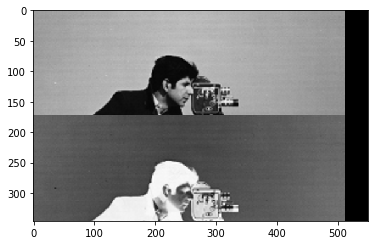

In [51]:
sample_filename = listdir(directory)[0]
print(sample_filename)
sample_path = "%s/%s" %(directory, sample_filename)

import skimage.external.tifffile as tiff
sample_image = tiff.imread(sample_path)

plt.imshow(sample_image, cmap='gray')
plt.show()

## Processing

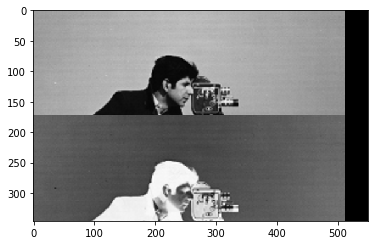

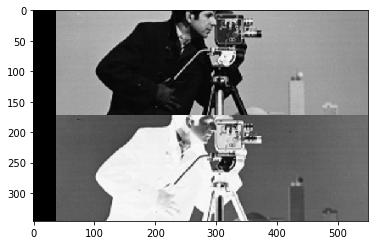

[(173, 550), array([ 60.,  38.])]


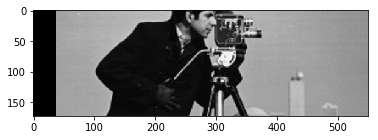

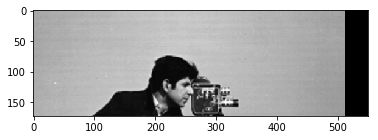

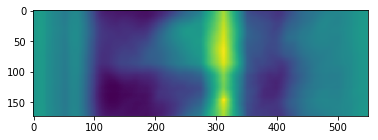

[0, 60.0] [[ 60.  38.]]
[346, 60.0, 286]
(2, 572, 550)


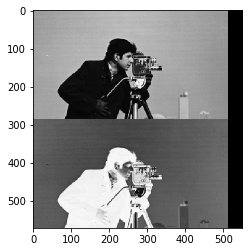

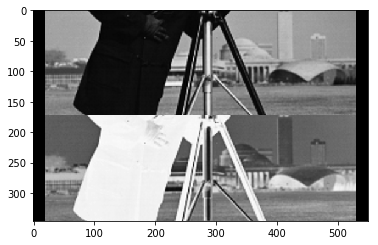

[(173, 550), array([ 61.,  19.])]


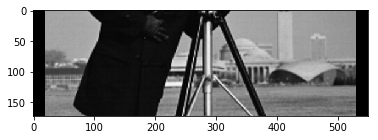

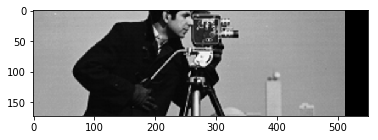

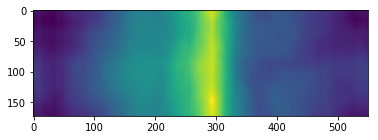

[0, 61.0] [[ 61.  19.]]
[459, 61.0, 398]
(2, 796, 550)


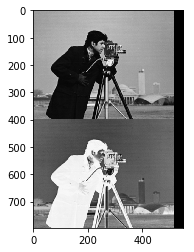

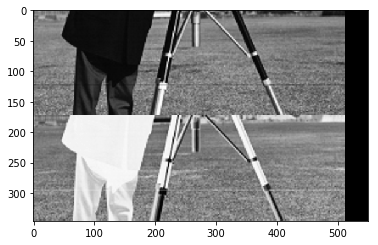

[(173, 550), array([ 60.,   0.])]


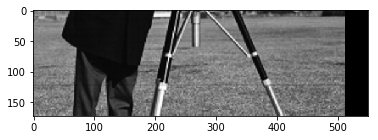

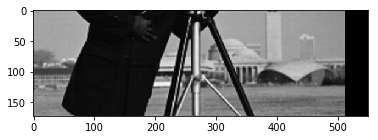

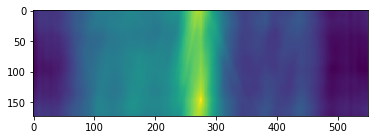

[0, 60.0] [[ 60.   0.]]
[571, 60.0, 511]
(2, 1022, 550)


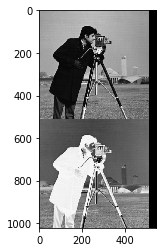

In [52]:
import numpy as np

path_format = '{strip_id:02d}_{strip_file_id:02d}.tif'
source_files = [path_format.format(strip_id=strip_id, strip_file_id=strip_file_id) for strip_id in range(number_of_strips) for strip_file_id in range(files_per_strip) ]

shape = sample_image.shape
pixcel_type = sample_image.dtype

def read_strip_files(stripe_id, files_per_strip, dtype, shape):
    mm_fd, mm_fname = tempfile.mkstemp(suffix='.memmap')    
    strip_mm = np.memmap(mm_fname, dtype=dtype, shape=(files_per_strip, shape[0], shape[1]))
    for file_id in range(files_per_strip):
        file_name = path_format.format(strip_id=stripe_id, strip_file_id=file_id)
        strip_mm[file_id] = tiff.imread("%s/%s" % (directory, file_name))
    
    return strip_mm

from skimage.feature import register_translation
import skimage
import os.path as op
from tempfile import mkdtemp

def find_shift(image1, image2):
    image2_cropped = image2[(image2.shape[0] - image1.shape[0]):,:]
    shift, error, diffphase = register_translation(image1, image2_cropped)
    
    print([image1.shape, shift])
    plt.imshow(image1, cmap='gray')
    plt.show()
    plt.imshow(image2_cropped, cmap='gray')
    plt.show()
    image_product = np.fft.fft2(image1) * np.fft.fft2(image2_cropped).conj()
    cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
    plt.imshow(cc_image.real)
    plt.show()
    
    return shift

def calc_coef(images_1, images_2, nchan, chan):
    if nchan > 1:
        images_1 = images_1[:,chan*images_1[0].shape[0]//nchan:(chan+1)*images_1[0].shape[0]//nchan,:]
        images_2 = images_2[:,chan*images_2[0].shape[0]//nchan:(chan+1)*images_2[0].shape[0]//nchan,:]
    
    shift = np.array([find_shift(images_1[0], images_2[0])])
    coef = [0, shift[0, 0]]
    return coef, shift

def apply_shift(image1, image2, shift, margin):
    cols1 = image1.shape[1]
    cols2 = image2.shape[1]
    rows1 = image1.shape[0]
    rows2 = image2.shape[0] 
    
    overlap = shift[0]
    registered = np.zeros((rows1 + rows2 - overlap, cols2), dtype=int)
    registered[:rows2-margin] = image2[:rows2-margin]
    if shift[1] >= 0:
        registered[rows2-margin:, :cols1-int(shift[1])] = image1[overlap-margin:, int(shift[1]):] 
    else:
        registered[rows2-margin:, abs(int(shift[1])):] = image1[overlap-margin:, :int(shift[1])] 
    
    if margin > 0:
        fade2 = image2[rows2 - margin:rows2] * np.arange(1, 0, -(1/margin))[:, np.newaxis]
        fade1 = np.zeros_like(fade2)
        if shift[1] >= 0:
            fade1[:, :cols1-int(shift[1])] = (image1[overlap-margin:overlap, int(shift[1]):] * 
                                              np.arange(0, 1, (1/margin))[:, np.newaxis])
        else:
            fade1[:, abs(int(shift[1])):] = image1[overlap-margin:overlap, :int(shift[1])] * np.arange(0, 1, (1/margin))[:, np.newaxis]

        registered[rows2 - margin:rows2] = fade1 + fade2

    return registered.astype(int)

def output_zstack(images_1, images_2, coef, shift, margin, chop_index, chan=0, current_stack=None, out_path=None):
    f3 = op.join(mkdtemp(), 'reg.dat')
    h3 = open(f3, 'w')
    registered = np.memmap(f3, dtype=images_1.dtype, shape=(len(images_1), chop_index, images_1[0].shape[1]))
    for z_level in range(len(images_1)):
        shift_zero = int(np.round(np.polyval(coef, z_level)))
        shift_one = int(np.round(np.mean(shift[:,1])))
        registered[z_level] = apply_shift(images_1[z_level], images_2[z_level], 
                                          [shift_zero, shift_one], margin)

    return registered


def stitch_zstack(images_1, images_2, nchan, chan, margin, current_stack=None, out_path=None):
    coef, shift = calc_coef(images_1, images_2, nchan, chan)
    print(coef, shift)
    if np.std(shift[:, 0]) > np.sqrt(len(images_1) // nchan): 
        warnings.warn("I am having trouble finding a good registration. Defaulting to no shift")
        shift = np.zeros(shift.shape)
        coef = np.zeros(coef.shape)
    overlap = coef[1]
    rows = (images_1[0].shape[0]+images_2[0].shape[0])//nchan
    chop_index = int(rows - overlap)
    print([rows, overlap, chop_index])
    if nchan == 1:
        return output_zstack(images_1, images_2, coef, shift, margin, chop_index, chan, current_stack=current_stack, out_path=out_path)

    if nchan > 1:       
        if isinstance(images_1, skimage.io.collection.ImageCollection):
            im_collection_list = []
            for chan_index in range(nchan):
                im_collection_list.append(output_zstack(
                    images_1[chan_index*images_1.shape[0]//nchan:(chan_index+1)*images_1.shape[0]//nchan,:],
                    images_2[chan_index*images_2.shape[0]//nchan:(chan_index+1)*images_2.shape[0]//nchan,:], 
                    coef, shift, chop_index, current_stack=current_stack, out_path=out_path))
            all_col_files = []
            for col in im_collection_list:
                all_col_files.extend(col.files)
            return imread_collection(all_col_files)    
        else:
            f3 = op.join(mkdtemp(), 'reg_nchan.dat')
            h3 = open(f3, 'w')
            registered = np.memmap(f3, dtype=images_1.dtype, shape=(len(images_1), chop_index*nchan, images_1[0].shape[1]))
            for chan_index in range(nchan):
                registered[:,chan_index*chop_index:(chan_index+1)*chop_index,:] = output_zstack(
                    images_1[:,chan_index*images_1[0].shape[0]//nchan:(chan_index+1)*images_1[0].shape[0]//nchan,:],
                    images_2[:,chan_index*images_2[0].shape[0]//nchan:(chan_index+1)*images_2[0].shape[0]//nchan,:], 
                    coef, shift, margin, chop_index, current_stack=current_stack, out_path=out_path)
            return registered 
        
stiched_stack = read_strip_files(0, files_per_strip, pixcel_type, shape)
plt.imshow(stiched_stack[0,:,:], cmap='gray')
plt.show()

margin=30

for ss in range(1, number_of_strips):
    strip = read_strip_files(ss, files_per_strip, pixcel_type, shape)
    plt.imshow(strip[0,:,:], cmap='gray')
    plt.show()

    stiched_stack = stitch_zstack(strip, stiched_stack, nchan, 0, margin)

    print(stiched_stack.shape)
    plt.imshow(stiched_stack[0,:,:], cmap='gray')
    plt.show()
    